# Assignment 3

## AI usage

I have used AI to understand better what the tasks were asking. It was also useful for troubleshooting on why plots didn't appear in the notebook. 

## Log

For this assignment I have also tried to work systematically through the tasks, starting with the Jupyter Notebook and completing the app after. 

I had a lot of work to do, as I haven't fully caught up with the lectures yet. To summarize and clarify certain instructions, AI has been very useful this time. 

Once again I got caught up in a couple things that didn't work at first (like understanding how to use DCT and IDCT and how to use and plot the STL), but I managed to calm down and have worked steadily since. 

## Links 

- Github: https://github.com/Satheris/IND320_SMAA
- Streamlit app: https://ind320smaa-2eg32uba6uhmrknkwtxzar.streamlit.app/

## Coding 

### Imports 

In [ ]:
import pandas as pd
import numpy as np
import pymongo
import streamlit as st

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import openmeteo_requests
import requests_cache
from retry_requests import retry

from scipy.fft import dct, idct
from scipy.stats import median_abs_deviation
from statsmodels.tsa.seasonal import STL
from sklearn.neighbors import LocalOutlierFactor

import plotly.io as pio
pio.renderers.default = "notebook+pdf"

### Download from openmeteo API

In [2]:
# dictionary for city geo-placement
citydict = {'priceArea': ['NO1', 'NO2', 'NO3', 'NO4', 'NO5'],
            'city': ['Oslo', 'Kristiansand', 'Bergen', 'Tromsø', 'Trondheim'],
            'longitude': [10.7461, 7.9956, 5.3242, 18.9551, 10.3951],
            'latitude': [59.9127, 58.1467, 60.393, 69.6489, 63.4305]}

city_df = pd.DataFrame(citydict).set_index('priceArea')
city_df

,city,longitude,latitude
priceArea,,,
NO1,Oslo,10.7461,59.9127
NO2,Kristiansand,7.9956,58.1467
NO3,Bergen,5.3242,60.3930
NO4,Tromsø,18.9551,69.6489
NO5,Trondheim,10.3951,63.4305


In [3]:
# Function for reading openmeteo data, from website

def openmeteo_download(longitude, latitude, year):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Make sure all required weather variables are listed here
    # The order of variables in hourly or daily is important to assign them correctly below
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
        "models": "era5",
        "timezone": "Europe/Berlin",
        "wind_speed_unit": "ms",
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]    
    # print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    # print(f"Elevation: {response.Elevation()} m asl")
    # print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
    # print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True).tz_convert('Europe/Oslo'),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True).tz_convert('Europe/Oslo'),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left",
    )}

    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["precipitation"] = hourly_precipitation

    df = pd.DataFrame(data = hourly_data)

    return df

In [4]:
# extracting geo-placement for Bergen
bergenLong = city_df.at['NO3', 'longitude']
bergenLat = city_df.at['NO3', 'latitude']

In [5]:
df = openmeteo_download(bergenLong, bergenLat, 2019)
df.head()

,date,temperature_2m,wind_direction_10m,wind_speed_10m,wind_gusts_10m,precipitation
0,2019-01-01 00:00:00+01:00,6.70,0.4,11.853270,260.776154,22.700001
1,2019-01-01 01:00:00+01:00,6.55,0.5,13.322162,277.765076,24.400000
2,2019-01-01 02:00:00+01:00,6.80,0.9,13.505925,296.375275,22.299999
3,2019-01-01 03:00:00+01:00,6.85,0.7,14.621901,310.006195,23.700001
4,2019-01-01 04:00:00+01:00,6.55,0.6,15.487092,314.215271,27.400000


### Outliers and anomalies 

#### Temperature analysis

The function performs a high-pass filtering using Direct Cosine Transform (DCT) to create seasonally adjusted temperature variations (SATV). This means that the low frequency cosine functions, which here represent longterm seasonal variation of the temperature, are filtered away. Using the SATV, the function finds the Median Absolute Deviation (MAD) and the given number of standard deviations (n_std) to find the upper and lower bounds of the expected temperature variation. The function returns `None`, but gives statistical and plot output.

In [6]:
def DCT_outlier_plot(df, column, dct_cutoff=10, n_std=3):
    # DCT of chosen variable -> transform to frequency domain
    dct_coefs = dct(df[column])

    # saving seasonal variation in low-pass filtering -> transform back to signal domain
    dct_coefs_lowpass = dct_coefs.copy()
    dct_coefs_lowpass[dct_cutoff:] = 0
    seasonal_variation = idct(dct_coefs_lowpass)

    # performing high-pass filtering -> transform back to signal domain
    dct_coefs_highpass = dct_coefs.copy()
    dct_coefs_highpass[:dct_cutoff] = 0
    satv = idct(dct_coefs_highpass)

    # finding the median absolute deviation (MAD) based on SATV
    MAD = median_abs_deviation(satv)

    # finding lower and upper bounds for the expected variation in year scale
    df['upper_bound'] = np.add(seasonal_variation, n_std*MAD)
    df['lower_bound'] = np.add(seasonal_variation, (-n_std)*MAD)

    # marking outliers in a separate column and removing data from inlier positions
    df['outliers'] = df[column].copy()
    df.loc[((df[column] < df['upper_bound']) & (df[column] > df['lower_bound'])), 'outliers'] = None

    # output statistics
    print(f'Number of outliers found: {(df["outliers"].count())}')
    print(f'Percentage of outliers: {(df["outliers"].count())/len(df["outliers"]):.3f}%')

    # line plot with temperature in original scale, upper and lower outlier bounds in original scale and outliers marked
    fig = px.line(df, x='date', y=[column, 'outliers', 'upper_bound', 'lower_bound'], template='plotly')
    fig.show()    

In [7]:
DCT_outlier_plot(df, 'temperature_2m', dct_cutoff=10, n_std=3)

Number of outliers found: 524
Percentage of outliers: 0.060%


#### Precipitation analysis

Function containing LocalOutlierFactor analysis, finding local anomalies. The function returns `None`, but gives statistical  and plot output.

In [8]:
def lof_stats_plot(df:pd.DataFrame, contamination=0.01, n_neighbors=20):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

    # making a reduced dataframe for analysis
    df_precipitation = pd.DataFrame(df['precipitation'])
    df_precipitation['date'] = df['date']
    df_precipitation['hour'] = pd.to_datetime(df_precipitation['date']).dt.hour
    df_precipitation['day_of_year'] = pd.to_datetime(df_precipitation['date']).dt.dayofyear

    # Use both precipitation and time features (else LOF gets confused)
    features = df_precipitation[['precipitation', 'hour', 'day_of_year']]
    pred_labels = lof.fit_predict(features)

    # convert (-1) to 0 -> bincount needs non-negative numbers
    pred_labels[pred_labels == -1] = 0

    # print for analysis results
    counts = np.bincount(pred_labels)
    print(f'LocalOutlierFactor found {counts[0]} outliers out of {sum(counts)} data points')
    print(f'The proportion of outliers is {counts[0]/sum(counts)*100:.3f}%')    
    
    # converting outlier information into dataframe format
    df_precipitation['category'] = pred_labels
    df_precipitation['outliers'] = df_precipitation['precipitation'].copy()
    df_precipitation.loc[(df_precipitation['category'] == 1), 'outliers'] = None

    # plotting with the outlier data
    fig = px.line(df_precipitation, x='date', y=['precipitation', 'outliers'], template='plotly')
    fig.show()

In [9]:
lof_stats_plot(df, contamination=0.01, n_neighbors=45)

LocalOutlierFactor found 88 outliers out of 8760 data points
The proportion of outliers is 1.005%


### Seasonal-Trend decomposition using LOESS (STL)

#### Connecting to MongoDB for data collection

In [10]:
def init_connection():
    return pymongo.MongoClient(st.secrets["mongo"]["uri"])

client = init_connection()

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [49]:
# Selecting a database and a collection
database = client['project']
collection = database['data']

try: 
    documents = collection.find({})
    documents = pd.DataFrame(list(documents))
except Exception as e:
    print(e)

In [50]:
df_elhub = documents.sort_values(by=['priceArea', 'productionGroup', 'startTime'])\
                .reset_index().set_index('_id').drop('index', axis=1)

df_elhub.head()

,priceArea,productionGroup,startTime,quantityKwh
_id,,,,
68ff61ddf09eaf22c14d6fae,NO1,hydro,2021-01-01T00:00:00+01:00,2507716.75
68ff61def09eaf22c14f86ab,NO1,hydro,2021-01-01T01:00:00+01:00,2494728.00
68ff61ddf09eaf22c14d7ac9,NO1,hydro,2021-01-01T02:00:00+01:00,2486777.50
68ff61def09eaf22c14ed531,NO1,hydro,2021-01-01T03:00:00+01:00,2461176.00
68ff61ddf09eaf22c14ddaec,NO1,hydro,2021-01-01T04:00:00+01:00,2466969.25


#### STL

In [68]:
def stl_plotter(df_elhub, area='NO1', prodGroup='wind', periodLength=12, 
                seasonalSmoother=3, trendSmoother=None, robust=True):
    # making subset of data 
    sub_df_elhub = df_elhub[(df_elhub['priceArea'] == area) & (df_elhub['productionGroup'] == prodGroup)]
    sub_df_elhub = pd.DataFrame(sub_df_elhub[['quantityKwh', 'startTime']])
    sub_df_elhub['startTime'] = pd.to_datetime(sub_df_elhub['startTime'], utc=True, errors='coerce').dt.tz_localize(None)

    # adding 1 hour because (utc=True) displaced the time
    sub_df_elhub['startTime'] = sub_df_elhub['startTime'] + pd.Timedelta(hours=1)

    # Let's make sure the index is properly set as datetime
    if not isinstance(sub_df_elhub.index, pd.DatetimeIndex):
        # If your time column is called 'startTime' and it's not the index
        sub_df_elhub = sub_df_elhub.set_index('startTime')
        
    # Ensure the index is timezone-naive if it has timezone info
    if sub_df_elhub.index.tz is not None:
        sub_df_elhub.index = sub_df_elhub.index.tz_localize(None)

    stl = STL(sub_df_elhub['quantityKwh'], period=periodLength, 
            seasonal=seasonalSmoother, trend=trendSmoother, robust=robust)

    res = stl.fit()
    fig = res.plot()
    plt.xticks(rotation=90)

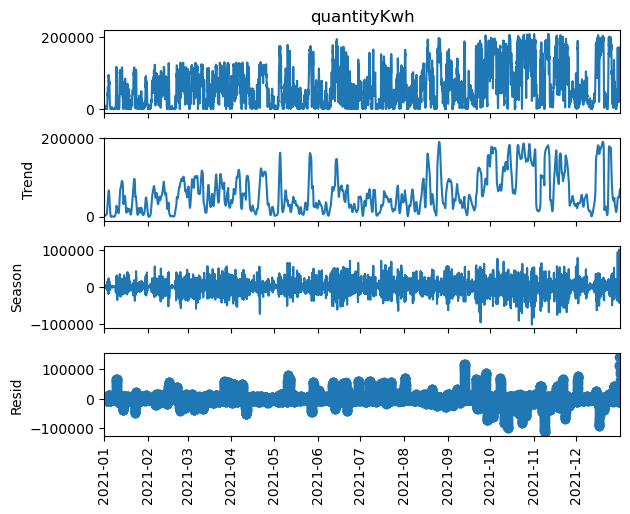

In [69]:
stl_plotter(df_elhub)

### Spectrogram

In [ ]:
# Our friend, the random series, but now a little longer
from scipy.signal import stft

rng = np.random.default_rng(0)
n = 2001
y = rng.standard_normal(n).cumsum()

In [7]:
# Compute the spectrogram
f, t, Zxx = stft(y, 2000, nperseg=100)

# Plot the series y and the spectrogram above each other
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1)
axs[0].plot(y)
axs[0].set_xlim(0, n-1)
axs[0].set_ylabel('Amplitude')
axs[1].pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud', vmax=1) # Play with the vmax parameter to enhance the contrast
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Intervals')
display(fig)

<Figure size 640x480 with 2 Axes>

In [10]:
import matplotlib.pyplot as plt
fs = 44100 # Sampling rate

y_approx = np.sin(2*np.pi*np.cumsum(f)/fs) # Approximation of the sine wave

plt.specgram(y_approx, Fs=fs, NFFT=1152, noverlap=400, scale='linear')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()


C:\Users\saraa\AppData\Local\Temp\ipykernel_328124\1095497721.py:6: UserWarning: Only one segment is calculated since parameter NFFT (=1152) >= signal length (=51).
  plt.specgram(y_approx, Fs=fs, NFFT=1152, noverlap=400, scale='linear')


### Testing for Streamlit app

In [11]:
def area_to_geoplacement(area):
    geo_dict = {'NO1': {'long': 10.7461, 'lat': 59.9127},
                'NO2': {'long': 7.9956, 'lat': 58.1467},
                'NO3': {'long': 5.3242, 'lat': 60.393},
                'NO4': {'long': 18.9551, 'lat': 69.6489},
                'NO5': {'long': 10.3951, 'lat': 63.4305}}
    
    return geo_dict[area]['long'], geo_dict[area]['lat']

area_to_geoplacement('NO2')

(7.9956, 58.1467)